In [1]:
%pylab inline
import pickle
import pprint

import numpy as np
import torch

from torch_geometric.datasets import HGBDataset

from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Config

In [2]:
root = '/lfs/rambo/1/vid/freebase'
dataset = HGBDataset(root, 'Freebase')

# Data

In [3]:
num_nodes_dict = {
    node_type: dataset[0][node_type].num_nodes
    for node_type in dataset[0].node_types 
}

In [4]:
path = f'{root}/freebase/col_dict.p'
col_dict = pickle.load(open(path, 'rb'))
edge_types = { index: edge_type for index, edge_type in enumerate(list(col_dict.keys())) }

In [5]:
node_types_start = {}
num_nodes = 0
start = 0

for node_type, node_count in num_nodes_dict.items():
    node_types_start[node_type] = start
    start += node_count
    num_nodes += node_count

In [6]:
train_idx = (dataset[0]['book'].train_mask).nonzero(as_tuple=True)[0] + node_types_start['book']
y_train = dataset[0]['book'].y[train_idx]
y_train_all = np.zeros((num_nodes,))
y_train_all[train_idx] = y_train + 1

# Heterogeneous Random Walks

In [7]:
path = f'{root}/freebase/random_walks_nodes.pt'
random_walks_nodes = torch.load(path)
path2 = f'{root}/freebase/random_walks_edge_types.pt'
random_walks_edge_types = torch.load(path2)

In [8]:
number_of_walks = random_walks_nodes.shape[0]
walk_length = random_walks_nodes.shape[1] - 1

In [21]:
labels = torch.from_numpy(y_train_all[torch.flatten(random_walks_nodes)].reshape(-1, walk_length + 1))
edge_types_counter = { edge_type: 0 for edge_type in edge_types.keys() }
metapath_counter_analysis = np.zeros((labels.shape[0], len(edge_types.values())))

In [22]:
walks_limit = 1000000

for i in range(walks_limit):
    start_label = labels[i, 0]
    same_label = labels[i] == start_label
    inds = torch.nonzero(same_label, as_tuple=True)[0]

    if inds.shape[0] == 1:
        if i > 0:
            metapath_counter_analysis[i] = metapath_counter_analysis[i - 1]
        continue
    
    for j in range(inds.shape[0] - 1):
        if random_walks_nodes[i, inds[j]] == random_walks_nodes[i, inds[j+1]]:
            continue
        else:
            between_edge_types = random_walks_edge_types[i, inds[j]:inds[j+1]]        
            between_edge_types = torch.unique_consecutive(between_edge_types)
            
            for edge_type in edge_types.keys():
                if str(edge_type) in str(between_edge_types):
                    edge_types_counter[edge_type] += 1
    
    # update analysis
    normalized_edge_types_counter = { key: value / sum(list(edge_types_counter.values())) for key, value in edge_types_counter.items() }
    keys, values = zip(*normalized_edge_types_counter.items())
    metapath_counter_analysis[i, keys] = values

/afs/cs.stanford.edu/u/vid/mag240m/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
print(edge_types_counter)
print(metapath_counter_analysis[:walks_limit])

{0: 49754, 1: 18697, 2: 8724, 3: 8319, 4: 9409, 5: 8759, 6: 4254, 7: 4115, 8: 3636, 9: 2288, 10: 744, 11: 574, 12: 145, 13: 164, 14: 159, 15: 237, 16: 219, 17: 204, 18: 236, 19: 418, 20: 359, 21: 411, 22: 808, 23: 528, 24: 3036, 25: 2623, 26: 369, 27: 470, 28: 215, 29: 151, 30: 577, 31: 485, 32: 442, 33: 271, 34: 611, 35: 226, 36: 388, 37: 318, 38: 286, 39: 482, 40: 370, 41: 473, 42: 509, 43: 330, 44: 123, 45: 98, 46: 241, 47: 533, 48: 317, 49: 428, 50: 283, 51: 399, 52: 373, 53: 2888, 54: 2615, 55: 347, 56: 271, 57: 153, 58: 101, 59: 265, 60: 487, 61: 278, 62: 385, 63: 410}
[[0.         0.         0.         ... 0.         0.         0.        ]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [0.33895141 0.12737417 0.05943265 ... 0.00189389 0.00262283 0.00279314]
 [0.33895141 0.12737417 0.05943265 ... 0.00189389 0.00262283 0.00279314]
 [0.33895141 0.12737417 0.05943265 ... 0.0018938

In [25]:
path = f'{root}/freebase/edge_types_counter.p'
path2 = f'{root}/freebase/metapath_counter_analysis.p'

pickle.dump(edge_types_counter, open(path, 'wb'), protocol=4)
pickle.dump(metapath_counter_analysis[:walks_limit], open(path2, 'wb'), protocol=4)

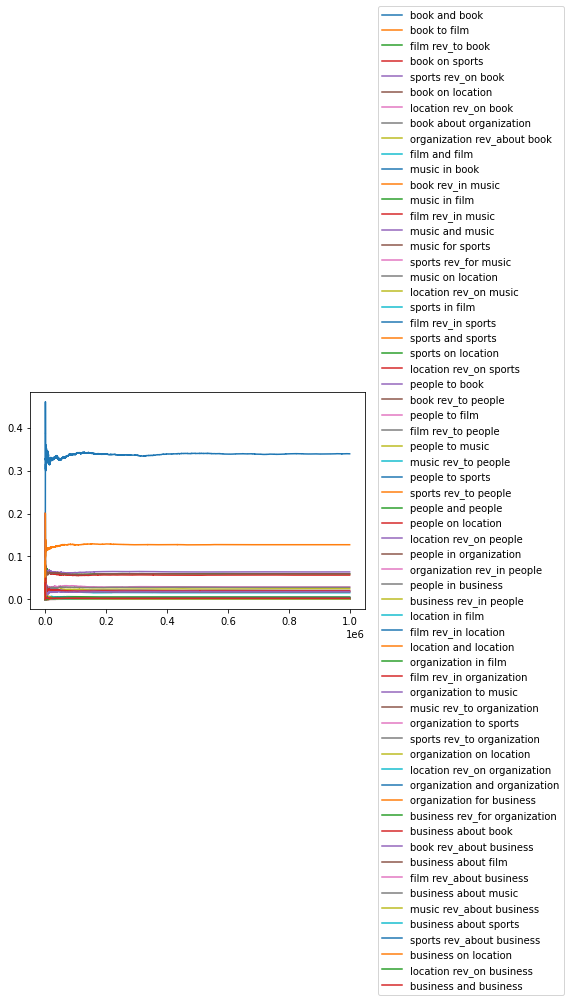

In [26]:
plt.plot(np.arange(walks_limit), metapath_counter_analysis[:walks_limit], label=edge_types.values())
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [27]:
for index, edge_type in enumerate(edge_types.values()):
    print(edge_type, metapath_counter_analysis[walks_limit - 1, index])

book and book 0.33895141292203723
book to film 0.12737417227566286
film rev_to book 0.0594326511703954
book on sports 0.056673570046597815
sports rev_on book 0.0640992451699049
book on location 0.05967109027985939
location rev_on book 0.02898057061885168
book about organization 0.028033626726980405
organization rev_about book 0.024770417200316103
film and film 0.015587105212960188
music in book 0.005068534212605935
book rev_in music 0.003910401395209417
music in film 0.0009878191677793824
film rev_in music 0.001117257541488405
music and music 0.001083194811564978
music for sports 0.001614573398370439
sports rev_for music 0.001491947570646102
music on location 0.0013897593808758209
location rev_on music 0.0016077608523857535
sports in film 0.002847644221598496
film rev_in sports 0.0024457040085020575
sports and sports 0.002799956399705698
sports on location 0.005504537155625801
location rev_on sports 0.0035970242799138893
people to book 0.020682889609504863
book rev_to people 0.01786930

In [28]:
metapath_counter_analysis[walks_limit - 1]

array([0.33895141, 0.12737417, 0.05943265, 0.05667357, 0.06409925,
       0.05967109, 0.02898057, 0.02803363, 0.02477042, 0.01558711,
       0.00506853, 0.0039104 , 0.00098782, 0.00111726, 0.00108319,
       0.00161457, 0.00149195, 0.00138976, 0.00160776, 0.00284764,
       0.0024457 , 0.00279996, 0.00550454, 0.00359702, 0.02068289,
       0.01786931, 0.00251383, 0.0032019 , 0.0014647 , 0.00102869,
       0.00393084, 0.00330408, 0.00301115, 0.0018462 , 0.00416247,
       0.00153964, 0.00264327, 0.00216639, 0.00194839, 0.00328365,
       0.00252064, 0.00322233, 0.00346759, 0.00224814, 0.00083794,
       0.00066763, 0.00164182, 0.00363109, 0.00215958, 0.00291577,
       0.00192795, 0.00271821, 0.00254108, 0.01967463, 0.01781481,
       0.00236395, 0.0018462 , 0.00104232, 0.00068807, 0.00180532,
       0.00331771, 0.00189389, 0.00262283, 0.00279314])